In [1]:
import os
import cv2
import glob
import math
import fitz
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import pytesseract as pyt

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from torch.utils.data import DataLoader

from PIL import Image, ImageOps

from diffusers import UNet2DModel, DDPMScheduler
from datasets import load_dataset, Dataset, Features, Value, Image as HfImage
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary

In [2]:
dirty = glob.glob("./data/bronze/denoising/train/clean/*.png")
dirty = glob.glob("./data/bronze/denoising/train/dirty/*.png")
test = glob.glob("./data/bronze/denoising/test/*.png")

data = [
    {"image_1": c, "image_2": d} for c, d in zip(dirty, dirty)
]

dataset = Dataset.from_list(data)

features = Features({
    "image_1": HfImage(),
    "image_2": HfImage()
})

dataset = dataset.cast(features)
print(dataset)

test_dataset = Dataset.from_list([{"image": c} for c in test])

features = Features({
    "image": HfImage(),
})

test_dataset = test_dataset.cast(features)
print(test_dataset)

Casting the dataset:   0%|          | 0/144 [00:00<?, ? examples/s]

Dataset({
    features: ['image_1', 'image_2'],
    num_rows: 144
})


Casting the dataset:   0%|          | 0/72 [00:00<?, ? examples/s]

Dataset({
    features: ['image'],
    num_rows: 72
})


In [3]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

In [4]:
def collate_train_fn(batch):
    images1 = []
    images2 = []
    for d in batch:
        img1 = transform(d['image_1'])
        img2 = transform(d['image_2'])
        images1.append(img1)
        images2.append(img2)
    return torch.stack(images1), torch.stack(images2)

def collate_test_fn(batch):
    images = []
    for d in batch:
        img = transform(d['image'])
        images.append(img)
    return torch.stack(images)

In [5]:
train_dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_train_fn)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_test_fn)
next(iter(train_dataloader))

(tensor([[[[0.8902, 0.8824, 0.8941,  ..., 0.8902, 0.8706, 0.8627],
           [0.9020, 0.8863, 0.8784,  ..., 0.8941, 0.8745, 0.8745],
           [0.8902, 0.8824, 0.8706,  ..., 0.9020, 0.8902, 0.8902],
           ...,
           [0.8941, 0.9020, 0.9020,  ..., 0.8824, 0.8588, 0.7373],
           [0.9059, 0.8980, 0.8941,  ..., 0.8745, 0.8902, 0.8941],
           [0.9020, 0.8941, 0.8941,  ..., 0.8902, 0.9059, 0.8902]]],
 
 
         [[[0.9373, 0.9137, 0.9059,  ..., 0.6588, 0.6863, 0.7255],
           [0.9294, 0.9137, 0.9059,  ..., 0.6392, 0.6706, 0.7176],
           [0.9176, 0.9137, 0.9059,  ..., 0.6039, 0.6392, 0.7059],
           ...,
           [0.8314, 0.8510, 0.8706,  ..., 0.7608, 0.7804, 0.8353],
           [0.8510, 0.8627, 0.8745,  ..., 0.7569, 0.7922, 0.8549],
           [0.8588, 0.8706, 0.8784,  ..., 0.7529, 0.8000, 0.8667]]],
 
 
         [[[0.8902, 0.8824, 0.8941,  ..., 0.8902, 0.8706, 0.8627],
           [0.9020, 0.8863, 0.8784,  ..., 0.8941, 0.8745, 0.8745],
           [0.8902

In [6]:
def get_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        if device.type == 'cuda':
            # Allow TensorFloat32 on matmul and convolutions
            torch.backends.cuda.matmul.allow_tf32 = True
            torch.backends.cudnn.allow_tf32 = True
            torch.set_float32_matmul_precision("medium")
        return device

device = get_device()
device

device(type='mps')

In [7]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.xavier_normal_(m.weight.data)
        torch.nn.init.constant_(m.bias.data, 0.0)

class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize=True, dropout=0.0):
        super(UNetDown, self).__init__()
        layers = [nn.Conv2d(in_size, out_size, 4, 2, 1, bias=False)]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
        layers.append(nn.LeakyReLU(0.2))
        if dropout:
            layers.append(nn.Dropout(dropout))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout=0.0):
        super(UNetUp, self).__init__()
        layers = [
            nn.ConvTranspose2d(in_size, out_size, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_size),
            nn.ReLU(inplace=True),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(GeneratorUNet, self).__init__()

        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        return self.final(u7)

class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False)
        )

    def forward(self, img_A, img_B):
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [8]:
generator = GeneratorUNet().to(device)
discriminator = Discriminator().to(device)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d((1, 0, 1, 0))
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [9]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [10]:
criterion_GAN = torch.nn.MSELoss()
criterion_pixelwise = torch.nn.L1Loss()

In [11]:
g_optimizer = torch.optim.AdamW(generator.parameters(), lr=0.0002, betas=(0.9, 0.999))
d_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=0.0002, betas=(0.9, 0.999))

In [12]:
epochs = 15
lambda_pixel = 100

In [13]:
def discriminator_train_step(real_src, real_trg, fake_trg):
    d_optimizer.zero_grad()

    prediction_real = discriminator(real_trg, real_src)
    error_real = criterion_GAN(prediction_real, torch.ones(len(real_src), 1, 32, 32).to(device))
    error_real.backward()

    prediction_fake = discriminator(fake_trg.detach(), real_src)
    error_fake = criterion_GAN(prediction_fake, torch.zeros(len(real_src), 1, 32, 32).to(device))
    error_fake.backward()

    d_optimizer.step()

    return error_real + error_fake

def generator_train_step(real_src, real_trg, fake_trg):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_trg, real_src)

    loss_GAN = criterion_GAN(prediction, torch.ones(len(real_src), 1, 32, 32).to(device))
    loss_pixel = criterion_pixelwise(fake_trg, real_trg)
    loss_G = loss_GAN + lambda_pixel * loss_pixel

    loss_G.backward()
    g_optimizer.step()
    return loss_G

In [ ]:
generator.train()
discriminator.train()

n = len(train_dataloader)
t = tqdm(total=epochs*n, position=0, leave=True)

for epoch in range(epochs):
    for batch in tqdm(train_dataloader):
        clean, dirty = [t.to(device) for t in batch]
        clean_trg = generator(dirty)

        errD = discriminator_train_step(dirty, clean, clean_trg)
        errG = generator_train_step(dirty, clean, clean_trg)

        t.update()

    logs = {"Epoch": epoch, "ErrorD": errD.item(), "ErrorG": errG.item()}
    t.set_postfix(**logs)

100%|██████████| 135/135 [05:37<00:00,  2.42s/it, Epoch=14, ErrorD=0.542, ErrorG=3.32]

In [ ]:
with open("model.pkl", "wb") as f:
    torch.save(generator, f)

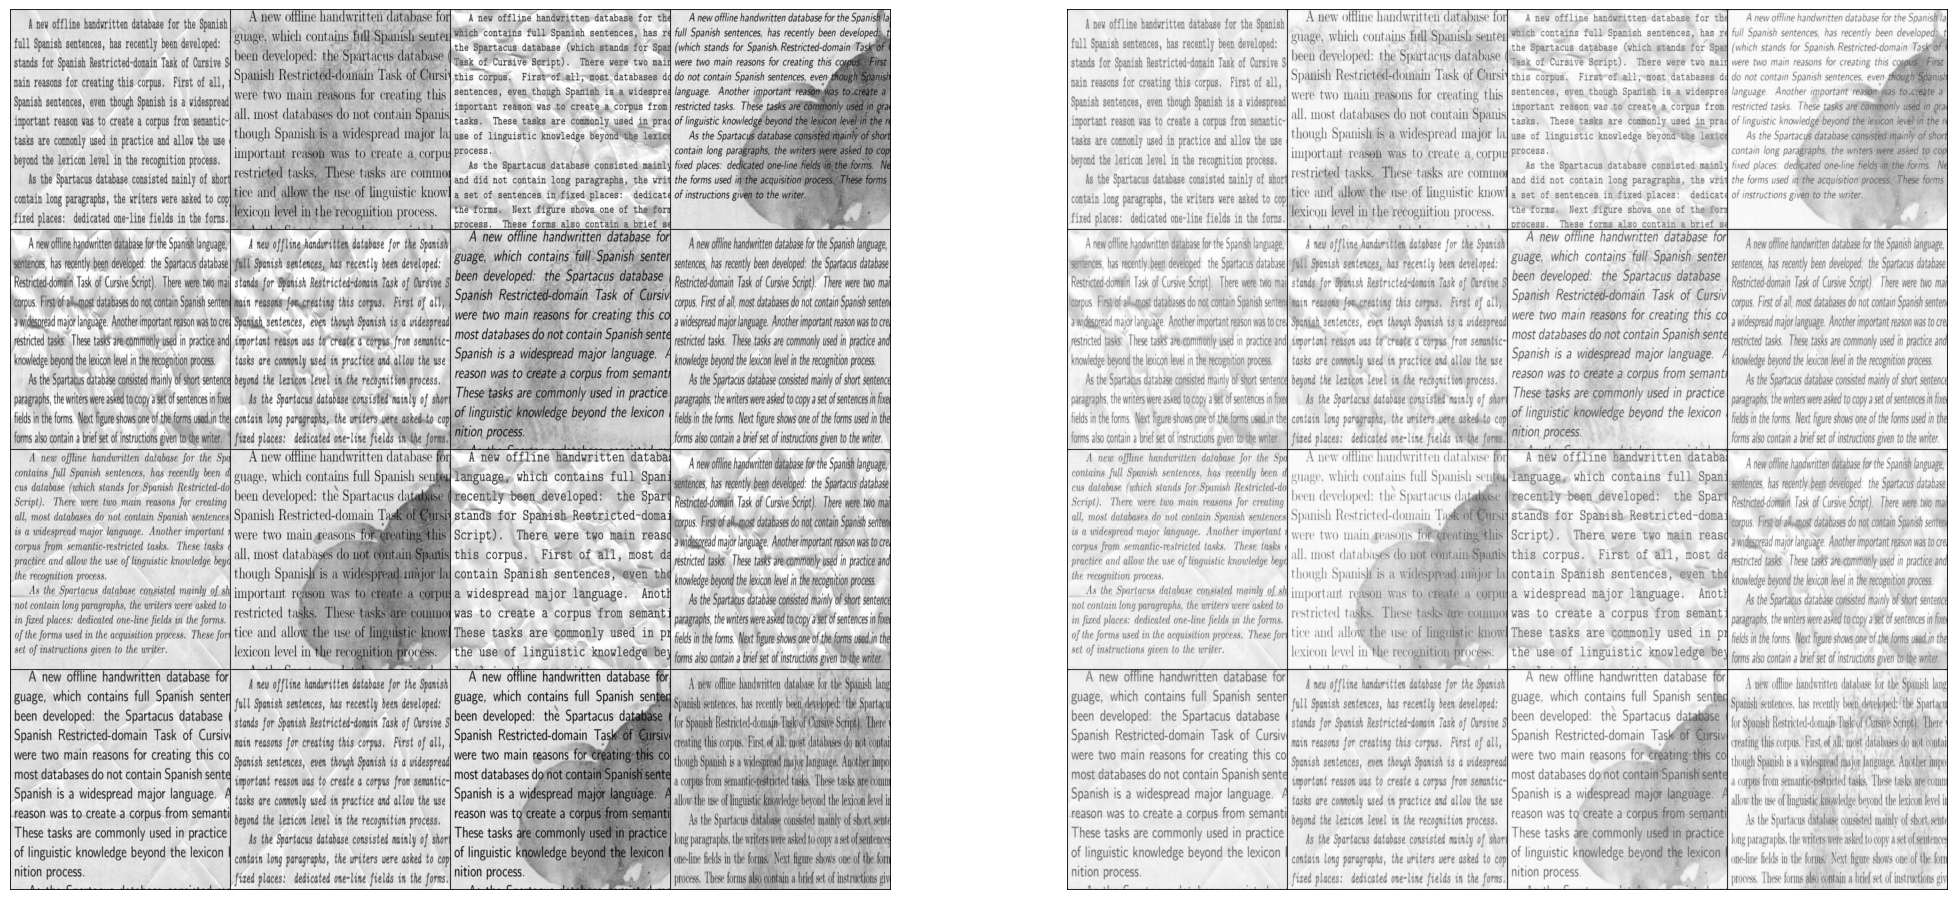

In [26]:
with open("model.pkl", "rb") as f:
    model = torch.load(f, weights_only=False)
model.eval()

data = next(iter(test_dataloader))
dirty = data.to(device)
fake_trg = model(dirty)

grid1 = vutils.make_grid(dirty, nrow=4, padding=2, normalize=True)
grid2 = vutils.make_grid(fake_trg, nrow=4, padding=2, normalize=True)

grid1 = grid1.permute(1, 2, 0).cpu()
grid2 = grid2.permute(1, 2, 0).cpu()

fig, axs = plt.subplots(1,2, figsize=(25,25))
axs = axs.ravel()
axs[0].imshow(grid1, cmap='gray')
axs[0].set_axis_off()
axs[1].imshow(grid2, cmap='gray')
axs[1].set_axis_off()
plt.show()